# Test two ways of embedding... same!?

In [35]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [36]:
# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173468e-02 -4.28515822e-02 -1.56286396e-02  1.40537601e-02
  3.95537689e-02  1.21796273e-01  2.94333566e-02 -3.17524076e-02
  3.54959667e-02 -7.93140009e-02  1.75878331e-02 -4.04369794e-02
  4.97259982e-02  2.54912656e-02 -7.18699992e-02  8.14968273e-02
  1.47072971e-03  4.79627140e-02 -4.50335816e-02 -9.92174894e-02
 -2.81769410e-02  6.45046160e-02  4.44670692e-02 -4.76217382e-02
 -3.52952257e-02  4.38671745e-02 -5.28565869e-02  4.33028938e-04
  1.01921476e-01  1.64071992e-02  3.26996557e-02 -3.45986784e-02
  1.21339448e-02  7.94871077e-02  4.58341092e-03  1.57778561e-02
 -9.68207605e-03  2.87626237e-02 -5.05806431e-02 -1.55793866e-02
 -2.87907384e-02 -9.62279178e-03  3.15556526e-02  2.27349345e-02
  8.71449709e-02 -3.85027751e-02 -8.84718895e-02 -8.75495560e-03
 -2.12343261e-02  2.08923966e-02 -9.02078152e-02 -5.25732562e-02
 -1.05638504e-02  2.88311224e-02 -1.61454976e-02  6.17839908e-03
 -1.23234

In [4]:
sentence

'The quick brown fox jumps over the lazy dog.'

In [6]:
embedding.shape

(384,)

In [21]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [22]:
encoded_input = tokenizer(sentences, max_length = 120, padding=True, truncation=True, return_tensors='pt')


In [23]:
encoded_input

{'input_ids': tensor([[  101,  2023,  7705, 19421,  7861,  8270,  4667,  2015,  2005,  2169,
          7953,  6251,   102],
        [  101, 11746,  2024,  2979,  2004,  1037,  2862,  1997,  5164,  1012,
           102,     0,     0],
        [  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
          1012,   102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}

In [24]:
with torch.no_grad():
    model_output = model(**encoded_input)


In [25]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [26]:
model_output['last_hidden_state']

tensor([[[ 0.2913, -0.2685, -0.2250,  ...,  0.4261,  0.0493, -0.2095],
         [-0.6272, -0.0421, -0.2452,  ...,  0.5336,  1.3115,  0.5999],
         [ 0.0023, -0.2805, -0.4198,  ..., -0.2900,  1.5808, -0.4912],
         ...,
         [ 0.1802, -0.5567,  0.0146,  ...,  0.9311,  0.5940, -0.3536],
         [ 0.0603, -0.2502,  0.5959,  ...,  0.9435,  0.9465, -1.0680],
         [-0.3356,  0.0650,  0.1109,  ...,  1.0801,  0.2653, -0.2762]],

        [[ 0.0856,  0.1876,  0.0488,  ...,  0.1204, -0.0907, -0.1662],
         [ 0.1291, -0.0266,  0.6318,  ...,  0.7958,  0.1555, -1.2737],
         [ 0.0062,  0.2263,  0.1851,  ...,  0.3981,  0.6461, -0.2192],
         ...,
         [ 0.3036,  0.3740,  0.2523,  ...,  0.6319,  0.5731, -0.2901],
         [-0.2124,  0.2626,  0.6867,  ...,  0.5504,  0.7065, -0.4728],
         [-0.2220,  0.2086,  0.6693,  ...,  0.5410,  0.5683, -0.3963]],

        [[ 0.0464,  0.3381,  0.2082,  ...,  0.2766, -0.0861, -0.0358],
         [ 0.1162,  0.2264,  0.1021,  ...,  0

In [27]:
# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[-0.0137, -0.0429, -0.0156,  ...,  0.1002,  0.1237, -0.0423],
        [ 0.0565,  0.0550,  0.0314,  ...,  0.0665,  0.0849, -0.0333],
        [ 0.0439,  0.0589,  0.0482,  ...,  0.0522,  0.0561,  0.1021]])


In [33]:
sentence_embeddings[0]

tensor([-1.3717e-02, -4.2852e-02, -1.5629e-02,  1.4054e-02,  3.9554e-02,
         1.2180e-01,  2.9433e-02, -3.1752e-02,  3.5496e-02, -7.9314e-02,
         1.7588e-02, -4.0437e-02,  4.9726e-02,  2.5491e-02, -7.1870e-02,
         8.1497e-02,  1.4707e-03,  4.7963e-02, -4.5034e-02, -9.9217e-02,
        -2.8177e-02,  6.4505e-02,  4.4467e-02, -4.7622e-02, -3.5295e-02,
         4.3867e-02, -5.2857e-02,  4.3306e-04,  1.0192e-01,  1.6407e-02,
         3.2700e-02, -3.4599e-02,  1.2134e-02,  7.9487e-02,  4.5835e-03,
         1.5778e-02, -9.6821e-03,  2.8763e-02, -5.0581e-02, -1.5579e-02,
        -2.8791e-02, -9.6228e-03,  3.1556e-02,  2.2735e-02,  8.7145e-02,
        -3.8503e-02, -8.8472e-02, -8.7550e-03, -2.1234e-02,  2.0892e-02,
        -9.0208e-02, -5.2573e-02, -1.0564e-02,  2.8831e-02, -1.6146e-02,
         6.1784e-03, -1.2323e-02, -1.0734e-02,  2.8335e-02, -5.2857e-02,
        -3.5862e-02, -5.9799e-02, -1.0906e-02,  2.9157e-02,  7.9798e-02,
        -3.2787e-04,  6.8350e-03,  1.3272e-02, -4.2

In [39]:
model.encode(sentences[0])

array([-1.37173338e-02, -4.28515710e-02, -1.56286471e-02,  1.40537657e-02,
        3.95537540e-02,  1.21796280e-01,  2.94333957e-02, -3.17523666e-02,
        3.54959443e-02, -7.93139935e-02,  1.75878275e-02, -4.04369980e-02,
        4.97259684e-02,  2.54912954e-02, -7.18699768e-02,  8.14968571e-02,
        1.47071178e-03,  4.79627401e-02, -4.50335778e-02, -9.92174894e-02,
       -2.81769447e-02,  6.45045936e-02,  4.44670618e-02, -4.76217158e-02,
       -3.52952294e-02,  4.38671671e-02, -5.28566092e-02,  4.33034380e-04,
        1.01921476e-01,  1.64072346e-02,  3.26996446e-02, -3.45986709e-02,
        1.21339560e-02,  7.94871375e-02,  4.58342489e-03,  1.57778393e-02,
       -9.68209561e-03,  2.87626348e-02, -5.05806506e-02, -1.55794034e-02,
       -2.87907310e-02, -9.62279923e-03,  3.15556377e-02,  2.27349326e-02,
        8.71449634e-02, -3.85027602e-02, -8.84718969e-02, -8.75494629e-03,
       -2.12343261e-02,  2.08924171e-02, -9.02078077e-02, -5.25732487e-02,
       -1.05638541e-02,  

In [42]:
model.encode(sentences[0])[:20]

array([-0.01371733, -0.04285157, -0.01562865,  0.01405377,  0.03955375,
        0.12179628,  0.0294334 , -0.03175237,  0.03549594, -0.07931399,
        0.01758783, -0.040437  ,  0.04972597,  0.0254913 , -0.07186998,
        0.08149686,  0.00147071,  0.04796274, -0.04503358, -0.09921749],
      dtype=float32)

In [43]:
sentence_embeddings[0][:20]

tensor([-0.0137, -0.0429, -0.0156,  0.0141,  0.0396,  0.1218,  0.0294, -0.0318,
         0.0355, -0.0793,  0.0176, -0.0404,  0.0497,  0.0255, -0.0719,  0.0815,
         0.0015,  0.0480, -0.0450, -0.0992])

In [29]:
encoded_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [32]:
model_output[0]

tensor([[[ 0.2913, -0.2685, -0.2250,  ...,  0.4261,  0.0493, -0.2095],
         [-0.6272, -0.0421, -0.2452,  ...,  0.5336,  1.3115,  0.5999],
         [ 0.0023, -0.2805, -0.4198,  ..., -0.2900,  1.5808, -0.4912],
         ...,
         [ 0.1802, -0.5567,  0.0146,  ...,  0.9311,  0.5940, -0.3536],
         [ 0.0603, -0.2502,  0.5959,  ...,  0.9435,  0.9465, -1.0680],
         [-0.3356,  0.0650,  0.1109,  ...,  1.0801,  0.2653, -0.2762]],

        [[ 0.0856,  0.1876,  0.0488,  ...,  0.1204, -0.0907, -0.1662],
         [ 0.1291, -0.0266,  0.6318,  ...,  0.7958,  0.1555, -1.2737],
         [ 0.0062,  0.2263,  0.1851,  ...,  0.3981,  0.6461, -0.2192],
         ...,
         [ 0.3036,  0.3740,  0.2523,  ...,  0.6319,  0.5731, -0.2901],
         [-0.2124,  0.2626,  0.6867,  ...,  0.5504,  0.7065, -0.4728],
         [-0.2220,  0.2086,  0.6693,  ...,  0.5410,  0.5683, -0.3963]],

        [[ 0.0464,  0.3381,  0.2082,  ...,  0.2766, -0.0861, -0.0358],
         [ 0.1162,  0.2264,  0.1021,  ...,  0

# Use this Embedding

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [48]:
# https://www.sbert.net/index.html

# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)


In [47]:
embeddings.shape

(3, 384)

# Load Data

In [1246]:
import sys
import os


sys.path.append("..")


import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm

from src.data_process import load_wls_adress_AddDomain

In [1247]:
from src.utils import number_split, create_mix

In [4]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

# Split

In [5]:
n_test = 150
train_test_ratio = 4


valid_full_settings = []
for combination in itertools.product([0.1, 0.5], 
                                    [0.2, 0.6], 
                                     np.arange(0.1, 0.999, 0.1),
                                     np.arange(0, 5, 0.05)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if number_setting is not None:
        valid_full_settings.append(number_setting)
    

In [6]:
len(valid_full_settings)

3236

In [7]:
valid_full_settings[0]

{'n_train': 600,
 'n_test': 150,
 'n_z0_pos_train': 54,
 'n_z0_neg_train': 486,
 'n_z0_pos_test': 16,
 'n_z0_neg_test': 119,
 'n_z1_pos_train': 12,
 'n_z1_neg_train': 48,
 'n_z1_pos_test': 1,
 'n_z1_neg_test': 14,
 'mix_param_dict': {'p_pos_train_z0': 0.1,
  'p_pos_train_z1': 0.2,
  'p_pos_train': 0.11000000000000001,
  'p_pos_test': 0.11000000000000001,
  'p_mix_z0': 0.9,
  'p_mix_z1': 0.1,
  'alpha_train': 2.0,
  'alpha_test': 0.30000000000000004,
  'p_pos_test_z0': 0.11827956989247312,
  'p_pos_test_z1': 0.03548387096774194,
  'C_y': 0.11000000000000001,
  'C_z': 0.1}}

In [8]:
dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= valid_full_settings[0])

In [9]:
dfs.keys()

dict_keys(['train', 'test', 'setting'])

In [10]:
dfs['train']

,file,text,idtlkbnk,age 2011,education,"category fluency version, 2011","category fluency, scored words named, 2011","> 1 sd below mean for normals ages 60-79 (Tombaugh, Kozak, & Rees, 1999) -- normal cutoff = 12+ for 9-12 yrs eductation, 14+ for 13-21 yrs education",label,domain,domain_index
0,2000014162,The mother is wiping a plate. The sink is runn...,2.000014e+09,73.0,15.0,2.0,-4.0,NaN,1,wls,0
1,2000005829,Okay. Two kids goofing around trying to get a ...,2.000006e+09,59.0,12.0,1.0,-3.0,NaN,1,wls,0
2,2000012182,Well the kid's up in the cookie jar. And the c...,2.000012e+09,71.0,12.0,2.0,10.0,Y,1,wls,0
3,2000013337,A sink overflowing. A stool about to tip over....,2.000013e+09,71.0,18.0,2.0,11.0,Y,1,wls,0
4,2000017694,Water spilling onto the floor from the sink. M...,2.000018e+09,72.0,12.0,1.0,-3.0,NaN,1,wls,0
...,...,...,...,...,...,...,...,...,...,...,...
595,280-1,Okay. I see a little girl telling her little b...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1
596,124-1,Okay. Water running outof the sink. Lady dryin...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1
597,042-2,Okay. Okay the boy is on the stool. the stool ...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1
598,071-2,Real action. Okay. reaching with an arm is tha...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1


In [11]:
dfs['test']

,file,text,idtlkbnk,age 2011,education,"category fluency version, 2011","category fluency, scored words named, 2011","> 1 sd below mean for normals ages 60-79 (Tombaugh, Kozak, & Rees, 1999) -- normal cutoff = 12+ for 9-12 yrs eductation, 14+ for 13-21 yrs education",label,domain,domain_index
0,2000007170,A woman that is washing dishes. And the cookie...,2.000007e+09,73.0,12.0,2.0,3.0,Y,1,wls,0
1,2000006264,Washing dishes. Sink overflowing. Coffee cups ...,2.000006e+09,69.0,12.0,2.0,-4.0,NaN,1,wls,0
2,2000009520,I see a kid falling off of the stool reaching ...,2.000010e+09,62.0,14.0,2.0,-4.0,NaN,1,wls,0
3,2000001314,Cookie jar. Carpet. Boy. Girl. Stool. Arms. Mo...,2.000001e+09,73.0,12.0,2.0,-3.0,NaN,1,wls,0
4,2000016469,I see a mother drying the dishes and the sink ...,2.000016e+09,72.0,14.0,1.0,9.0,Y,1,wls,0
...,...,...,...,...,...,...,...,...,...,...,...
145,021-1,Okay. Many or the mother's washing the dishes ...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1
146,709-0,Okay. Well in the first place the the mother f...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1
147,280-2,Everything that's going on okay. mother's wipi...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1
148,121-2,the boy reaching standing on a stool which is ...,NaN,NaN,NaN,NaN,NaN,NaN,0,adress,1


# Sentence BERT

## Encode

In [12]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [13]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

## Logistic Regression

### All

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

In [335]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [336]:
clf.fit(X=embeddings_X_train, y=y_train)

LogisticRegression(C=1, solver='liblinear')

In [337]:
clf.classes_

array([0, 1])

In [338]:
y_probs = clf.predict_proba(X=embeddings_X_test)

In [339]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

0.22278914641018177

### t-SNE

In [96]:
from sklearn.manifold import TSNE

In [104]:
embeddings_X_train

array([[-0.02603805,  0.03508905,  0.01144288, ...,  0.07411144,
         0.07927023, -0.02159295],
       [-0.05684517, -0.04484358,  0.03489798, ...,  0.04343555,
        -0.00171118,  0.07127645],
       [-0.02551708, -0.00503572,  0.00249544, ...,  0.04548871,
         0.03084787,  0.06419715],
       ...,
       [-0.06515338, -0.04773206,  0.02018634, ...,  0.11873141,
         0.04420635,  0.0004137 ],
       [-0.01309393, -0.06973479,  0.01656789, ...,  0.03183706,
        -0.07742386,  0.06660209],
       [ 0.01403351, -0.0308989 , -0.01105002, ...,  0.06612104,
        -0.03713397,  0.02680786]], dtype=float32)

In [340]:
x_train_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_train)
x_test_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_test)



In [341]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [342]:
clf.fit(X=x_train_tsne, y=y_train)

LogisticRegression(C=1, solver='liblinear')

In [343]:
clf.classes_

array([0, 1])

In [344]:
y_probs = clf.predict_proba(X=x_test_tsne)

In [345]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

0.08532493753336037

In [346]:
# metrics.roc_auc_score(
#                 y_true=y_test,
#                 y_score=y_probs[:,1],
#             )

# metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

# TFIDF

In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [184]:
vectorizer = TfidfVectorizer(use_idf = True,
                                    ngram_range = (1,1))

In [185]:
vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

TfidfVectorizer()

In [186]:
x_train_tfidf = vectorizer.transform(dfs['train']['text']).toarray()
x_test_tfidf = vectorizer.transform(dfs['test']['text']).toarray()

## Logistic Regression

### All features

In [199]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [200]:
clf.fit(X=x_train_tfidf, y=y_train)

LogisticRegression(C=1, solver='liblinear')

In [201]:
clf.classes_

array([0, 1])

In [202]:
y_probs = clf.predict_proba(X=x_test_tfidf)

In [203]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

0.24864769950779703

### t-SNE

In [219]:
x_train_tfidf_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_train_tfidf)
x_test_tfidf_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_test_tfidf)



In [287]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [288]:
clf.fit(X=x_train_tfidf_tsne, y=y_train)

LogisticRegression(C=1, solver='liblinear')

In [289]:
clf.classes_

array([0, 1])

In [290]:
y_probs = clf.predict_proba(X=x_test_tfidf_tsne)

In [291]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

0.21360386178009094

In [292]:
metrics.roc_auc_score(
                y_true=y_test,
                y_score=y_probs[:,1],
            )

0.5975232198142415

In [293]:
metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

0.15384615384615383

### PCA

In [227]:
from sklearn.decomposition import PCA

In [280]:
pca = PCA(n_components=5)

In [294]:
x_train_tfidf_pca = pca.fit_transform(x_train_tfidf)
x_test_tfidf_pca = pca.fit_transform(x_test_tfidf)


In [310]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [311]:
clf.fit(X=x_train_tfidf_pca, y=y_train)

LogisticRegression(C=1, solver='liblinear')

In [312]:
clf.classes_

array([0, 1])

In [313]:
y_probs = clf.predict_proba(X=x_test_tfidf_pca)

In [314]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

0.18736232970580613

# Confound: statistical adjustment

## One-hot vector for z

In [329]:
v = 1
confound_map = {"wls":0, "adress":v}

dfs['train']['confound'] = dfs['train']['domain'].map(confound_map)

dfs['test']['confound'] = dfs['test']['domain'].map(confound_map)


## Sentence BERT

### Encode

In [347]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [348]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

### Logistic Regression

#### All Features

In [349]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [350]:
embeddings_X_train

array([[-0.02603805,  0.03508905,  0.01144288, ...,  0.07411144,
         0.07927023, -0.02159295],
       [-0.05684517, -0.04484358,  0.03489798, ...,  0.04343555,
        -0.00171118,  0.07127645],
       [-0.02551708, -0.00503572,  0.00249544, ...,  0.04548871,
         0.03084787,  0.06419715],
       ...,
       [-0.06515338, -0.04773206,  0.02018634, ...,  0.11873141,
         0.04420635,  0.0004137 ],
       [-0.01309393, -0.06973479,  0.01656789, ...,  0.03183706,
        -0.07742386,  0.06660209],
       [ 0.01403351, -0.0308989 , -0.01105002, ...,  0.06612104,
        -0.03713397,  0.02680786]], dtype=float32)

In [358]:
x_embeddings_confound_train = np.concatenate([embeddings_X_train, np.array(dfs['train']['confound']).reshape(-1,1)], axis=1)


In [381]:
shape_test = embeddings_X_test.shape

a = np.empty((shape_test[0],1))
a.fill(0)
x_embeddings_confound_test_z0 = np.concatenate([embeddings_X_test, a], axis=1)

a = np.empty((shape_test[0],1))
a.fill(v)
x_embeddings_confound_test_z1 = np.concatenate([embeddings_X_test, a], axis=1)

In [359]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

LogisticRegression(C=1, solver='liblinear')

In [360]:
clf.classes_

array([0, 1])

In [383]:
y_probs_z0 = clf.predict_proba(X=x_embeddings_confound_test_z0)
y_probs_z1 = clf.predict_proba(X=x_embeddings_confound_test_z1)

In [389]:
p_z = []

# NOTE: the order here is important!!! Here, wls -> df0, adress -> df1
p_z.append(sum(dfs['train']['domain'] == 'wls')/len(dfs['train']))
p_z.append(sum(dfs['train']['domain'] == 'adress')/len(dfs['train']))


In [390]:
p_z

[0.9, 0.1]

In [400]:
y_probs_z0[:5,:]

array([[0.81631369, 0.18368631],
       [0.89267514, 0.10732486],
       [0.87749738, 0.12250262],
       [0.78990643, 0.21009357],
       [0.90697533, 0.09302467]])

In [401]:
y_probs_z0[:5,:] * p_z[0]

array([[0.73468232, 0.16531768],
       [0.80340762, 0.09659238],
       [0.78974764, 0.11025236],
       [0.71091579, 0.18908421],
       [0.81627779, 0.08372221]])

In [402]:
y_probs_z1[:5,:]

array([[0.66147373, 0.33852627],
       [0.78527262, 0.21472738],
       [0.7590066 , 0.2409934 ],
       [0.62308443, 0.37691557],
       [0.81085109, 0.18914891]])

In [403]:
y_probs_z1[:5,:] * p_z[1]

array([[0.06614737, 0.03385263],
       [0.07852726, 0.02147274],
       [0.07590066, 0.02409934],
       [0.06230844, 0.03769156],
       [0.08108511, 0.01891489]])

In [410]:
y_probs_confound = y_probs_z0 * p_z[0] + y_probs_z1 * p_z[1]

In [411]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

0.21089476120335973

# Confound: statistical adjustment

## Dummy Coding for z

In [478]:
z_Categories = ["wls","adress"]
n_zCats = len(z_Categories)

y_Categories = [0,1]
n_yCats = len(y_Categories)

In [439]:
pd.Categorical(dfs['train']['domain'], categories=z_Categories)

['wls', 'wls', 'wls', 'wls', 'wls', ..., 'adress', 'adress', 'adress', 'adress', 'adress']
Length: 600
Categories (2, object): ['wls', 'adress']

In [445]:
pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v

,confounder_wls,confounder_adress
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
595,0,1
596,0,1
597,0,1
598,0,1


In [446]:
confounders_train = pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v
confounders_test = pd.get_dummies(pd.Categorical(dfs['test']['domain'], categories=z_Categories), prefix="confounder") * v


## Sentence BERT

### Encode

In [347]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [476]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

n_test = len(y_test)

In [477]:
n_test

150

### Logistic Regression

#### All Features

In [441]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [442]:
embeddings_X_train

array([[-0.02603805,  0.03508905,  0.01144288, ...,  0.07411144,
         0.07927023, -0.02159295],
       [-0.05684517, -0.04484358,  0.03489798, ...,  0.04343555,
        -0.00171118,  0.07127645],
       [-0.02551708, -0.00503572,  0.00249544, ...,  0.04548871,
         0.03084787,  0.06419715],
       ...,
       [-0.06515338, -0.04773206,  0.02018634, ...,  0.11873141,
         0.04420635,  0.0004137 ],
       [-0.01309393, -0.06973479,  0.01656789, ...,  0.03183706,
        -0.07742386,  0.06660209],
       [ 0.01403351, -0.0308989 , -0.01105002, ...,  0.06612104,
        -0.03713397,  0.02680786]], dtype=float32)

In [447]:

x_embeddings_confound_train = np.concatenate([embeddings_X_train, confounders_train], axis=1)


In [448]:
len(z_Categories)

2

In [ ]:
a = np.empty(())

In [458]:
x_embeddings_confound_test_ls = []

for i in range(n_zCats):
    

    a = np.empty((n_test, n_zCats))
    a.fill(0)
    a[:,i] = v
    _ = np.concatenate([embeddings_X_test, a], axis=1)
    x_embeddings_confound_test_ls.append(_)

In [459]:
x_embeddings_confound_test_ls[0]

array([[-5.19096255e-02,  2.37105563e-02,  6.33640289e-02, ...,
        -5.27659096e-02,  1.00000000e+00,  0.00000000e+00],
       [-5.03195226e-02,  1.38752989e-03,  7.97736421e-02, ...,
         4.04432118e-02,  1.00000000e+00,  0.00000000e+00],
       [ 2.04415135e-02, -7.40002329e-03,  1.53832352e-02, ...,
         4.48168851e-02,  1.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.35588551e-02, -2.11666487e-02,  7.61096627e-02, ...,
         1.33295003e-02,  1.00000000e+00,  0.00000000e+00],
       [-6.08669557e-02, -1.94041766e-02,  2.05635056e-02, ...,
         2.46513027e-05,  1.00000000e+00,  0.00000000e+00],
       [-4.40657474e-02, -2.67091324e-03, -6.96919952e-03, ...,
         1.15973502e-03,  1.00000000e+00,  0.00000000e+00]])

In [460]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

LogisticRegression(C=1, solver='liblinear')

In [461]:
clf.classes_

array([0, 1])

In [462]:
y_probs_ls = []

for i in range(n_zCats):
    _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
    y_probs_ls.append(_y_probs)


In [464]:
p_z = []

for i in z_Categories:
    p_z.append(sum(dfs['train']['domain'] == i)/len(dfs['train']))

In [465]:
p_z

[0.9, 0.1]

In [480]:
y_probs_confound = np.empty((n_test, n_yCats))
y_probs_confound.fill(0)

In [482]:
for i in range(n_zCats):
    y_probs_confound += y_probs_ls[i] * p_z[i]

In [466]:
y_probs_confound = y_probs_ls[0] * p_z[0] + y_probs_ls[1] * p_z[1]

In [485]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

0.21058636072919867

# Build for multiple runs

In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [230]:
import sys
import os


sys.path.append("..")


import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm

from src.data_process import load_wls_adress_AddDomain
from src.process_SHAC import load_SHAC

In [3]:
from src.utils import number_split, create_mix

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

## WLS/Pitts

In [5]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

## SHAC

In [255]:
base_dir = "/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge"

df_shac = load_SHAC(base_dir=base_dir)

In [248]:
df_shac

,id,Drug,Alcohol,Tobacco,SubstanceAgg,set,location,text
0,3407,True,NaN,NaN,True,train,uw,Social History: Work: Unemployed Lives with m...
1,3313,False,True,False,True,train,uw,SOCIAL HISTORY: Living situation: Comfortabl...
2,3045,True,False,True,True,train,uw,HABITS: Tobacco Use: Approximately 20 pack-ye...
3,4399,False,True,True,True,train,uw,Social History: Immigrated from [LOCATION] in ...
4,3637,False,False,True,True,train,uw,HABITS: Tobacco Use: Formerly smoked 1-2 ciga...
...,...,...,...,...,...,...,...,...
4400,2884,True,True,NaN,True,test,mimic,Social History: lives w/ mother in [**Name2 (N...
4401,2728,NaN,NaN,True,True,test,mimic,Social History: lives with wife (recent nursin...
4402,2854,False,True,True,True,test,mimic,"Social History: quit smoking several yrs ago, ..."
4403,2726,False,False,False,False,test,mimic,"Social History: Denies Tob, EtOH, or Illicit d..."


In [260]:
outlabels = ['Drug','Alcohol','Tobacco','SubstanceAgg']
for i in outlabels:
    print(sum(df_shac[i].isna()))

1256
765
786
0


In [249]:
# Replace NaN in status for False.
# NOTE: this assumption may not be true!
df_shac = df_shac.replace(np.NaN, False)

In [250]:
df_shac['domain'] = df_shac['location']

In [251]:
df_shac_uw = df_shac.query("location == 'uw'").reset_index(drop=True)
df_shac_mimic = df_shac.query("location == 'mimic'").reset_index(drop=True)


## IMDB Horror vs Family

In [660]:
df_imdb = pd.read_csv("../data/aclImdb/horror_family.csv")

In [661]:
df_imdb

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain
0,8286,Larry Fessenden has been thrashed by most of t...,pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8286,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
1,8279,This film is more about how children make sens...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8279,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
2,8273,If you want Scream or anything like the big-st...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8273,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
3,8276,"Now this is what I'm talking about. Finally, a...",pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8276,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
4,8281,"From the first scene, I was really excited. ""I...",pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8281,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,4268,I remembered this show from when i was a kid. ...,neg,1,http://www.imdb.com/title/tt0366068/usercomments,tt0366068,neg_4268,train,tvSeries,Photon,Photon,0,1986,\N,\N,"Action,Adventure,Family",Family
5612,4519,"Three Stooges - Have Rocket, Will Travel - 195...",neg,3,http://www.imdb.com/title/tt0052880/usercomments,tt0052880,neg_4519,train,movie,Have Rocket -- Will Travel,Have Rocket -- Will Travel,0,1959,\N,76,"Comedy,Family,Sci-Fi",Family
5613,11260,"This movie should be called ""plan 9 from josep...",neg,4,http://www.imdb.com/title/tt0382958/usercomments,tt0382958,neg_11260,train,video,Saturday's Warrior,Saturday's Warrior,0,1989,\N,115,"Drama,Family,Musical",Family
5614,11474,This relic of a short film starts with a teen ...,neg,1,http://www.imdb.com/title/tt0150255/usercomments,tt0150255,neg_11474,train,tvMovie,Dad... Can I Borrow the Car?,Dad... Can I Borrow the Car?,0,1970,\N,22,"Comedy,Family",Family


In [668]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [669]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_family = df_imdb.query("domain == 'Family'").reset_index(drop=True)


In [663]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_family.groupby("label").size())

label
neg    3055
pos    1167
dtype: int64
label
neg    612
pos    782
dtype: int64


In [670]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_family.groupby("label_binary").size())

label_binary
0    3055
1    1167
dtype: int64
label_binary
0    612
1    782
dtype: int64


## IMDB Horror vs Documentary

In [780]:
df_imdb = pd.read_csv("../data/aclImdb/horror_documentary.csv")

In [781]:
df_imdb

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain
0,8286,Larry Fessenden has been thrashed by most of t...,pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8286,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
1,8279,This film is more about how children make sens...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8279,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
2,8273,If you want Scream or anything like the big-st...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8273,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
3,8276,"Now this is what I'm talking about. Finally, a...",pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8276,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
4,8281,"From the first scene, I was really excited. ""I...",pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8281,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,10869,A friend of mine lent this video to me and I w...,neg,1,http://www.imdb.com/title/tt0180826/usercomments,tt0180826,neg_10869,train,video,Metallica: Cunning Stunts,Metallica: Cunning Stunts,0,1998,\N,130,"Documentary,Music",Documentary
4991,12376,This collection really sucks!<br /><br />I ren...,neg,1,http://www.imdb.com/title/tt0324355/usercomments,tt0324355,neg_12376,train,video,Ultimate Fights from the Movies,Ultimate Fights from the Movies,0,2002,\N,53,Documentary,Documentary
4992,11896,"Before I start, I _love_ Eddie Izzard. I think...",neg,4,http://www.imdb.com/title/tt0342317/usercomments,tt0342317,neg_11896,train,video,Eddie Izzard: Circle,Eddie Izzard: Circle,0,2002,\N,82,"Comedy,Documentary",Documentary
4993,9050,I saw this film in its entirety in the 1960s &...,neg,1,http://www.imdb.com/title/tt0260369/usercomments,tt0260369,neg_9050,train,short,Signal 30,Signal 30,0,1959,\N,28,"Documentary,Short",Documentary


In [782]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [783]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_documentary = df_imdb.query("domain == 'Documentary'").reset_index(drop=True)


In [784]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_documentary.groupby("label").size())

label
neg    3055
pos    1167
dtype: int64
label
neg    276
pos    497
dtype: int64


In [785]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_documentary.groupby("label_binary").size())

label_binary
0    3055
1    1167
dtype: int64
label_binary
0    276
1    497
dtype: int64


In [787]:
500/776

0.6443298969072165

## IMDB Horror vs non Horror

In [943]:
df_imdb = pd.read_csv("../data/aclImdb/horror_nonhorror.csv")

In [944]:
df_imdb

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain
0,8286,Larry Fessenden has been thrashed by most of t...,pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8286,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
1,8279,This film is more about how children make sens...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8279,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
2,8273,If you want Scream or anything like the big-st...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8273,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
3,8276,"Now this is what I'm talking about. Finally, a...",pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8276,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
4,8281,"From the first scene, I was really excited. ""I...",pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8281,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23791,5955,"Using tons of stock footage, not only from Tra...",neg,3,http://www.imdb.com/title/tt0028345/usercomments,tt0028345,neg_5955,train,movie,Tarzan Escapes,Tarzan Escapes,0,1936,\N,89,"Action,Adventure,Family",nonHorror
23792,6361,Wow this movie sucked big time. I heard this m...,neg,1,http://www.imdb.com/title/tt0328258/usercomments,tt0328258,neg_6361,train,movie,Pinpon,Pinpon,0,2002,\N,114,"Comedy,Drama,Sport",nonHorror
23793,11113,"I often feel like Scrooge, slamming movies tha...",neg,3,http://www.imdb.com/title/tt0045815/usercomments,tt0045815,neg_11113,train,movie,The Girl Next Door,The Girl Next Door,0,1953,\N,92,"Comedy,Musical",nonHorror
23794,4237,JUDAAI was a bold film by Raj Kanwar at it's t...,neg,3,http://www.imdb.com/title/tt0119427/usercomments,tt0119427,neg_4237,train,movie,Judaai,Judaai,0,1997,\N,167,"Comedy,Drama,Romance",nonHorror


In [945]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [946]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_nonhorror = df_imdb.query("domain == 'nonHorror'").reset_index(drop=True)


In [947]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_nonhorror.groupby("label").size())

label
neg    3055
pos    1167
dtype: int64
label
neg     8857
pos    10717
dtype: int64


In [949]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_nonhorror.groupby("label_binary").size())

label_binary
0    3055
1    1167
dtype: int64
label_binary
0     8857
1    10717
dtype: int64


In [950]:
10/18

0.5555555555555556

In [1022]:
# del df_imdb_horror, df_imdb_nonhorror, df_imdb, df_imdb_family, df_imdb_documentary

In [1266]:
valid_full_settings[0]['mix_param_dict']

{'p_pos_train_z0': 0.3,
 'p_pos_train_z1': 0.9,
 'p_pos_train': 0.36000000000000004,
 'p_pos_test': 0.36000000000000004,
 'p_mix_z0': 0.9,
 'p_mix_z1': 0.1,
 'alpha_train': 3.0,
 'alpha_test': 0.05,
 'p_pos_test_z0': 0.3977900552486188,
 'p_pos_test_z1': 0.01988950276243094,
 'C_y': 0.36000000000000004,
 'C_z': 0.1}

In [ ]:
 "_".join([str(x) for x in valid_full_settings[0]['mix_param_dict']])

'p_pos_train_z0_p_pos_train_z1_p_pos_train_p_pos_test_p_mix_z0_p_mix_z1_alpha_train_alpha_test_p_pos_test_z0_p_pos_test_z1_C_y_C_z'

In [1277]:
"_".join([f"{k}_{v:.4f}" for k,v in valid_full_settings[0]['mix_param_dict'].items()])

'p_pos_train_z0_0.3000_p_pos_train_z1_0.9000_p_pos_train_0.3600_p_pos_test_0.3600_p_mix_z0_0.9000_p_mix_z1_0.1000_alpha_train_3.0000_alpha_test_0.0500_p_pos_test_z0_0.3978_p_pos_test_z1_0.0199_C_y_0.3600_C_z_0.1000'

## Yelp Seafoof: FL vs PA

In [1024]:
df_FL = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_FL.csv")
df_PA = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_PA.csv")

## Yelp Mexican: AZ vs MO

In [1067]:
df_AZ = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_AZ.csv")
df_MO = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_MO.csv")

## Yelp Year: before(and in) 2015 vs after(and in) 2020

In [1131]:
df_before2015 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_before2015.csv")
df_after2020 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_after2020.csv")

## Split

In [458]:
# n_test = 150
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.1], 
#                                      [0.5], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.1)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1025]:
# # imdb setting
# n_test = 500
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.3], 
#                                      [0.5], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.1)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1037]:
# # yelp seafood PA vs FL setting
# n_test = 500
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.8], 
#                                      [0.6], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1068]:
# # yelp mexican AZ vs MO setting
# n_test = 500
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.65], 
#                                      [0.5], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1214]:
# yelp year before 2015 vs after 2020 setting
n_test = 10000
train_test_ratio = 4


valid_full_settings = []
for combination in itertools.product([0.3], 
                                     [0.9], 
                                     np.arange(0.1, 0.9, 0.1),
                                     np.arange(0, 10, 0.05)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [1215]:
len(valid_full_settings)

890

In [1216]:
test_settings = []
for one_setting in valid_full_settings:
    # _a = round(one_setting['mix_param_dict']['p_mix_z1'],2) == 0.2
    _c = one_setting['mix_param_dict']['alpha_test'] == 5
    
    if _c:
        test_settings.append(one_setting)

In [1217]:
len(test_settings)

3

In [1249]:
valid_full_settings[0]

{'n_train': 40000,
 'n_test': 10000,
 'n_z0_pos_train': 10800,
 'n_z0_neg_train': 25200,
 'n_z0_pos_test': 3580,
 'n_z0_neg_test': 5420,
 'n_z1_pos_train': 3600,
 'n_z1_neg_train': 400,
 'n_z1_pos_test': 20,
 'n_z1_neg_test': 980,
 'mix_param_dict': {'p_pos_train_z0': 0.3,
  'p_pos_train_z1': 0.9,
  'p_pos_train': 0.36000000000000004,
  'p_pos_test': 0.36000000000000004,
  'p_mix_z0': 0.9,
  'p_mix_z1': 0.1,
  'alpha_train': 3.0,
  'alpha_test': 0.05,
  'p_pos_test_z0': 0.3977900552486188,
  'p_pos_test_z1': 0.01988950276243094,
  'C_y': 0.36000000000000004,
  'C_z': 0.1}}

## Logistic Regression

In [1218]:
from sklearn.feature_extraction.text import CountVectorizer

In [1219]:
from tqdm import tqdm

In [1220]:
random.seed(123)
print(random.randint(0,100))
print(random.randint(0,100))

6
34


In [1259]:
pd.DataFrame({"dd":np.array([1,2,3,9,12])}).to_csv("tt.csv", index=False)

In [ ]:
transform = "Sentence-BERT"
# transform = "binaryUnigram"


model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["wls","adress"]
# label='label'
# z_Categories = ["uw","mimic"]
# label='Drug'
# n_zCats = len(z_Categories)

# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

z_Categories = ["<=2015",">=2020"]
label='label'
n_zCats = len(z_Categories)
txt_col = "text"
domain_col = 'year_cut'
df0 = df_before2015
df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)

# add confounder. v is the scale for confounder
v = 1

# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# C=0.5
penalty = "l2"
solver = "lbfgs"
C = 1

auprc_logistic_confounder = []
auprc_logistic_vanilla = []
valid_n_full_settings = []



random.seed(123)

for c in tqdm(valid_full_settings):
# for c in test_settings:


    # create train/test split according to stats
    # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
    # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
    dfs = create_mix(df0=df0, df1=df1, target=label, setting= c, sample=False, seed=random.randint(0,1000))

    if dfs is None:
        continue
    valid_n_full_settings.append(c)


    if transform == "Sentence-BERT":
        # use Sentence-BERT to encode sentences
        x_transform_train = model.encode(dfs['train'][txt_col])
        x_transform_test = model.encode(dfs['test'][txt_col])
    if transform == "binaryUnigram":
        x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
        x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()

# tfidf could be tricky...
# https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
#     elif transform == "tfidf":
#         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

#         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

#         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
#         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

    y_train = dfs['train'][label]
    y_test = dfs['test'][label]

    n_test = len(y_test)




    confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
    confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


    #####################  Confound: statistical Adjustment
    clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

    # for training set: add confounder as dummy variables
    x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

    # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
    x_embeddings_confound_test_ls = []

    for i in range(n_zCats):
        a = np.empty((n_test, n_zCats))
        a.fill(0)
        a[:,i] = v
        _ = np.concatenate([x_transform_test, a], axis=1)
        x_embeddings_confound_test_ls.append(_)


    # fit the training data, add confounding dummy variables as predictors
    clf.fit(X=x_embeddings_confound_train, y=y_train)

    # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
    y_probs_ls = []

    for i in range(n_zCats):
        _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
        y_probs_ls.append(_y_probs)


    # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
    p_z = []

    for i in z_Categories:
        p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


    # calculate P(Y|X): sum(P(y|x,z) * P(z))
    y_probs_confound = np.empty((n_test, n_yCats))
    y_probs_confound.fill(0)

    for i in range(n_zCats):
        y_probs_confound += y_probs_ls[i] * p_z[i]



    auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))


    #####################  Simple Logistic Regression, WITHOUT confounder
    clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

    clf_vanilla.fit(X=x_transform_train, y=y_train)


    y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


    auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))

  8%|▊         | 74/890 [1:29:28<16:55:52, 74.70s/it]

In [1250]:
valid_n_full_settings[0]

{'n_train': 40000,
 'n_test': 10000,
 'n_z0_pos_train': 10800,
 'n_z0_neg_train': 25200,
 'n_z0_pos_test': 3580,
 'n_z0_neg_test': 5420,
 'n_z1_pos_train': 3600,
 'n_z1_neg_train': 400,
 'n_z1_pos_test': 20,
 'n_z1_neg_test': 980,
 'mix_param_dict': {'p_pos_train_z0': 0.3,
  'p_pos_train_z1': 0.9,
  'p_pos_train': 0.36000000000000004,
  'p_pos_test': 0.36000000000000004,
  'p_mix_z0': 0.9,
  'p_mix_z1': 0.1,
  'alpha_train': 3.0,
  'alpha_test': 0.05,
  'p_pos_test_z0': 0.3977900552486188,
  'p_pos_test_z1': 0.01988950276243094,
  'C_y': 0.36000000000000004,
  'C_z': 0.1}}

In [1222]:
p_z

[0.2, 0.8]

In [1223]:
df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                        "auprc_logistic_vanilla": auprc_logistic_vanilla})

In [1224]:

for k in valid_n_full_settings[0]['mix_param_dict'].keys():
    df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]
    

In [1225]:
df_eval

,auprc_logistic_confounder,auprc_logistic_vanilla,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
0,0.951956,0.950984,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.05,0.397790,0.019890,0.36,0.1
1,0.953041,0.953006,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.10,0.395604,0.039560,0.36,0.1
2,0.948117,0.948227,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.15,0.393443,0.059016,0.36,0.1
3,0.955247,0.954592,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.20,0.391304,0.078261,0.36,0.1
4,0.956344,0.955935,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.25,0.389189,0.097297,0.36,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0.992209,0.993310,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.75,0.097500,0.950625,0.78,0.8
886,0.992304,0.993478,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.80,0.097015,0.950746,0.78,0.8
887,0.992093,0.993120,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.85,0.096535,0.950866,0.78,0.8
888,0.992584,0.993595,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.90,0.096059,0.950985,0.78,0.8


In [1226]:
df_eval.query("(alpha_test == 5)")

,auprc_logistic_confounder,auprc_logistic_vanilla,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
486,0.985641,0.987638,0.3,0.9,0.66,0.66,0.4,0.6,3.0,5.0,0.194118,0.970588,0.66,0.6
605,0.989207,0.990829,0.3,0.9,0.72,0.72,0.3,0.7,3.0,5.0,0.189474,0.947368,0.72,0.7
790,0.992223,0.993410,0.3,0.9,0.78,0.78,0.2,0.8,3.0,5.0,0.185714,0.928571,0.78,0.8


In [1227]:
# df_imdb_sbert = df_eval.copy()

In [1228]:
# df_imdb_unigram = df_eval.copy()

In [1229]:
# df_eval = df_imdb_sbert.copy()

## Plot results

In [1230]:
df_eval['alpha_test'].unique()

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 ,
       2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75,
       2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 ,
       3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85,
       3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 ,
       4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95,
       5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45, 5.5 ,
       5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  , 6.05,
       6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55, 6.6 ,
       6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 , 7.15,
       7.2 , 7.25, 7.3 , 7.35, 7.4 , 7.45, 7.5 , 7.

In [1231]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [1232]:
df_eval['p_pos_train_z0'].unique()

array([0.3])

In [1233]:
df_eval['p_pos_train_z1'].unique()

array([0.9])

In [1234]:
# df = df_eval.query("(p_pos_train_z0 == 0.3) & (p_pos_train_z1 == 0.6)")
df = df_eval

In [1235]:
df['alpha_train'].unique()

array([3.])

In [1236]:
len(df['p_mix_z1'].unique())

8

In [1237]:
import math

def oneKL(a,b):
    return a * math.log(a/b)

def KL(distrA, distrB):
    # D_KL(P||Q): D_KL(A||B)
    ret = 0
    for a,b in zip(distrA, distrB):
        ret += oneKL(a,b)
    return ret

In [1238]:
df

,auprc_logistic_confounder,auprc_logistic_vanilla,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
0,0.951956,0.950984,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.05,0.397790,0.019890,0.36,0.1
1,0.953041,0.953006,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.10,0.395604,0.039560,0.36,0.1
2,0.948117,0.948227,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.15,0.393443,0.059016,0.36,0.1
3,0.955247,0.954592,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.20,0.391304,0.078261,0.36,0.1
4,0.956344,0.955935,0.3,0.9,0.36,0.36,0.9,0.1,3.0,0.25,0.389189,0.097297,0.36,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0.992209,0.993310,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.75,0.097500,0.950625,0.78,0.8
886,0.992304,0.993478,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.80,0.097015,0.950746,0.78,0.8
887,0.992093,0.993120,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.85,0.096535,0.950866,0.78,0.8
888,0.992584,0.993595,0.3,0.9,0.78,0.78,0.2,0.8,3.0,9.90,0.096059,0.950985,0.78,0.8


In [1239]:
# df['distance_KL_Test_Train'] = df.apply(lambda x: KL([1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
#                                                            [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']]
#                                                           ),
#                                               axis=1
#                                              )

In [1240]:
df['distance_KL_Train_Test'] = df.apply(lambda x: KL([1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                     [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                           
                                                          ),
                                              axis=1
                                             )

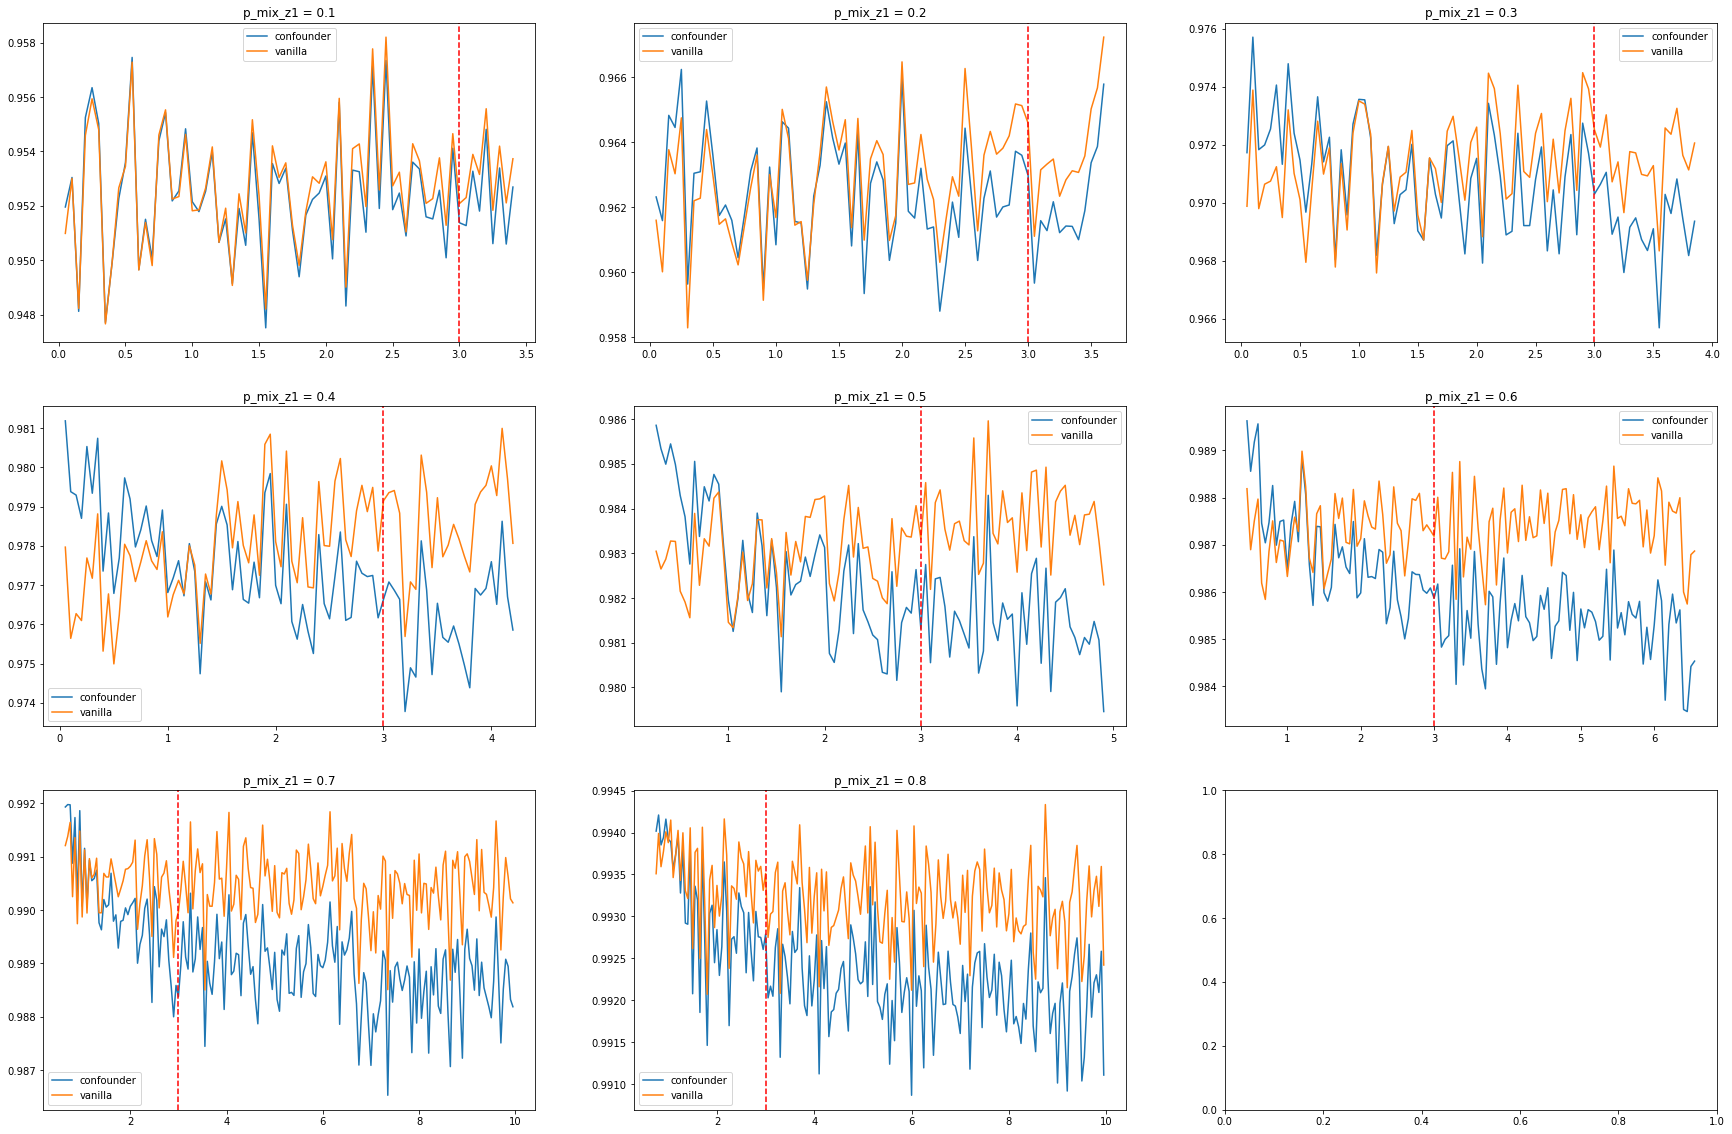

In [1241]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(30,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    _df = df[df['p_mix_z1'] == k].sort_values("alpha_test")
    ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_confounder'], label="confounder")
    ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_vanilla'], label="vanilla")
    
    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

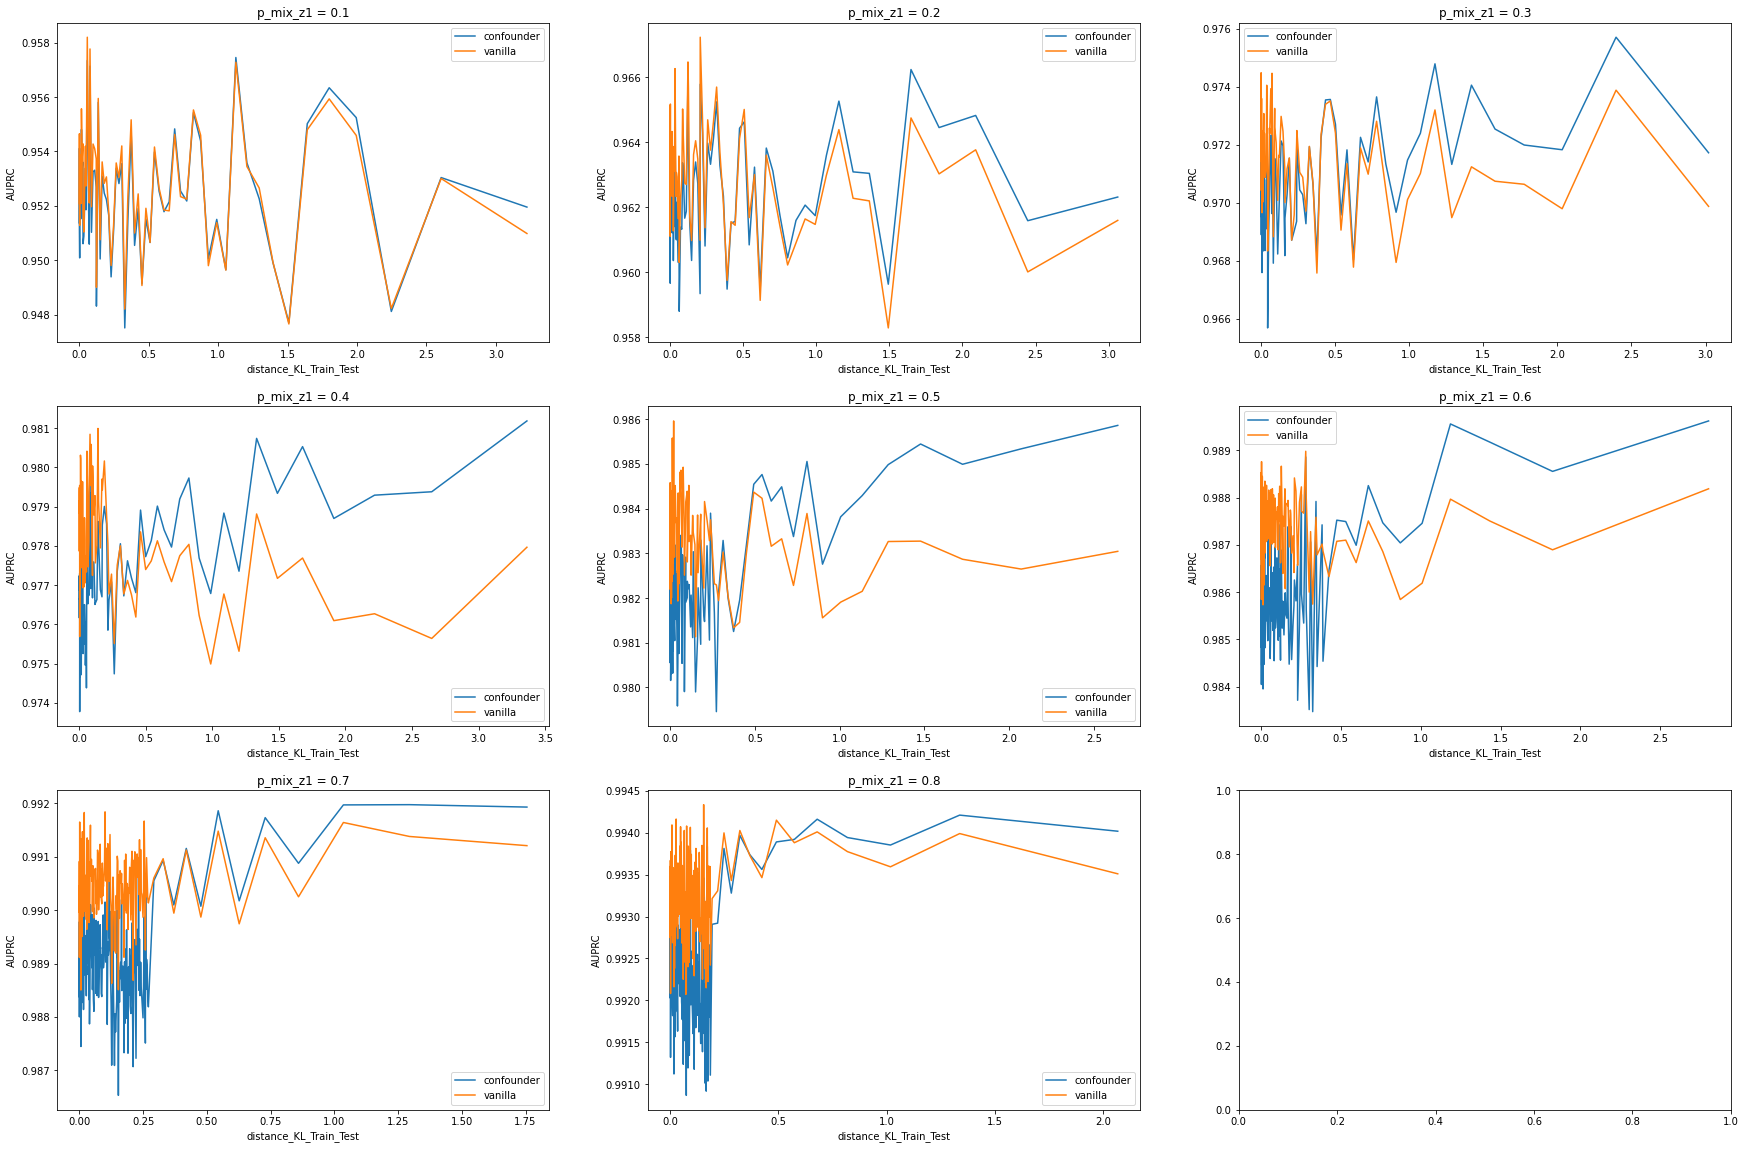

In [1242]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(30,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    ax[idx].plot(_df[xlabel], _df['auprc_logistic_confounder'], label="confounder")
    ax[idx].plot(_df[xlabel], _df['auprc_logistic_vanilla'], label="vanilla")
    
    ax[idx].set_xlabel(xlabel)
    ax[idx].set_ylabel("AUPRC")
    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

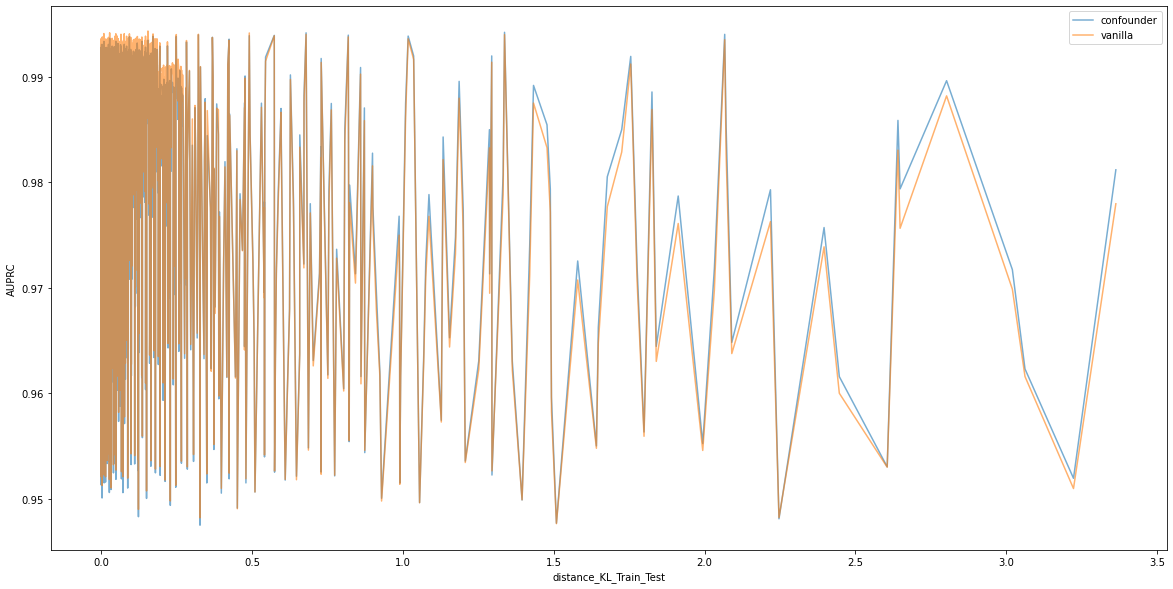

In [1243]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(1,1, figsize=(20,10))

xlabel = "distance_KL_Train_Test"
_df = df.sort_values(xlabel)
ax.plot(_df[xlabel], _df['auprc_logistic_confounder'], label="confounder", alpha=0.6)
ax.plot(_df[xlabel], _df['auprc_logistic_vanilla'], label="vanilla", alpha=0.6)

ax.set_xlabel(xlabel)
ax.set_ylabel("AUPRC")
# ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
ax.legend()
    

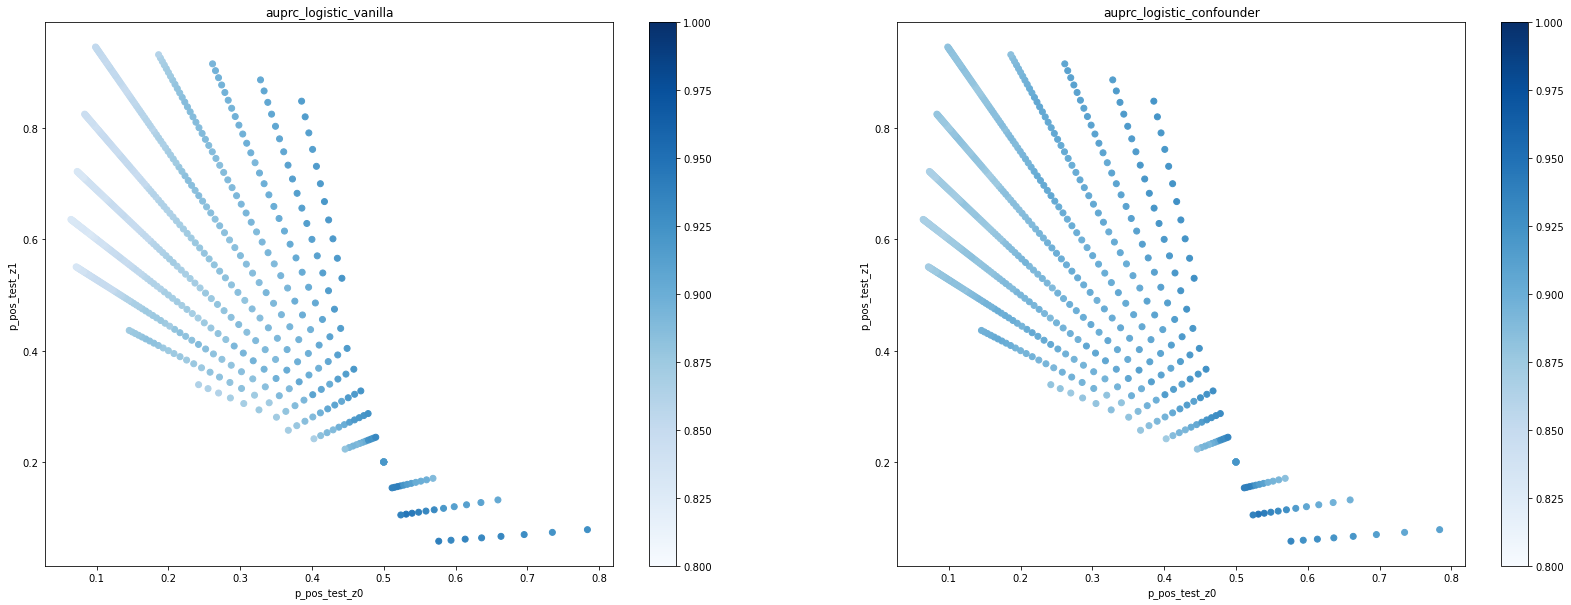

In [624]:
from matplotlib import cm

fig, ax = plt.subplots(1,2, figsize=(28,10))
xlabel = "distance_KL_Test_Train"
_df = df.sort_values(xlabel)

for idx, k in enumerate(["auprc_logistic_vanilla", "auprc_logistic_confounder"]):
    
    im = ax[idx].scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df[k], cmap='Blues')
    im.set_clim(0.8,1)
    ax[idx].set_xlabel("p_pos_test_z0")
    ax[idx].set_ylabel("p_pos_test_z1")
    ax[idx].set_title(k)

    fig.colorbar(im, ax=ax[idx])

In [612]:
# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_confounder"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.xlabel("p_pos_test_z0")
# plt.ylabel("p_pos_test_z1")
# plt.title("AUPRC of LR with confounder")

# fig.colorbar(im, ax=ax)

# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_vanilla"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.title('vanilla LR')
# fig.colorbar(im, ax=ax)

In [536]:
df

,auprc_logistic_confounder,auprc_logistic_vanilla,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,distance_KL_Test_Train
0,0.926364,0.921623,0.5,0.2,0.455,0.455,0.85,0.15,0.4,1.2,0.441748,0.530097,0.455,0.15,0.273482
1,0.923144,0.917751,0.5,0.2,0.455,0.455,0.85,0.15,0.4,1.3,0.435407,0.566029,0.455,0.15,0.331792
2,0.923004,0.917837,0.5,0.2,0.455,0.455,0.85,0.15,0.4,1.4,0.429245,0.600943,0.455,0.15,0.393647
3,0.923839,0.918548,0.5,0.2,0.455,0.455,0.85,0.15,0.4,1.5,0.423256,0.634884,0.455,0.15,0.458800
4,0.925025,0.919664,0.5,0.2,0.455,0.455,0.85,0.15,0.4,1.6,0.417431,0.667890,0.455,0.15,0.527071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,0.884397,0.889644,0.5,0.2,0.290,0.290,0.30,0.70,0.4,0.3,0.568627,0.170588,0.290,0.70,0.012261
637,0.889317,0.891976,0.5,0.2,0.290,0.290,0.30,0.70,0.4,0.4,0.500000,0.200000,0.290,0.70,0.000000
638,0.880414,0.880545,0.5,0.2,0.290,0.290,0.30,0.70,0.4,0.5,0.446154,0.223077,0.290,0.70,0.007429
639,0.873773,0.867298,0.5,0.2,0.290,0.290,0.30,0.70,0.4,0.6,0.402778,0.241667,0.290,0.70,0.024197


In [574]:
df.query("0.67 < distance_KL_Test_Train < 0.75").sort_values("distance_KL_Test_Train")

,auprc_logistic_confounder,auprc_logistic_vanilla,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,distance_KL_Test_Train
353,0.878078,0.850609,0.5,0.2,0.365,0.365,0.55,0.45,0.4,3.9,0.158351,0.617570,0.365,0.45,0.670258
461,0.881324,0.847419,0.5,0.2,0.350,0.350,0.50,0.50,0.4,4.8,0.120690,0.579310,0.350,0.50,0.670575
573,0.880416,0.843730,0.5,0.2,0.335,0.335,0.45,0.55,0.4,6.1,0.088042,0.537057,0.335,0.55,0.672427
6,0.922544,0.915945,0.5,0.2,0.455,0.455,0.85,0.15,0.4,1.8,0.406250,0.731250,0.455,0.15,0.672542
147,0.905784,0.887236,0.5,0.2,0.395,0.395,0.65,0.35,0.4,2.8,0.242331,0.678528,0.395,0.35,0.675203
574,0.880416,0.843730,0.5,0.2,0.335,0.335,0.45,0.55,0.4,6.2,0.086788,0.538083,0.335,0.55,0.676947
462,0.881324,0.847419,0.5,0.2,0.350,0.350,0.50,0.50,0.4,4.9,0.118644,0.581356,0.350,0.50,0.678156
248,0.885782,0.863961,0.5,0.2,0.380,0.380,0.60,0.40,0.4,3.3,0.197917,0.653125,0.380,0.40,0.678723
575,0.879312,0.842112,0.5,0.2,0.335,0.335,0.45,0.55,0.4,6.3,0.085568,0.539080,0.335,0.55,0.681363
354,0.876517,0.848810,0.5,0.2,0.365,0.365,0.55,0.45,0.4,4.0,0.155319,0.621277,0.365,0.45,0.682301


## Check some diagnosis

### Corr Plot

<AxesSubplot:>

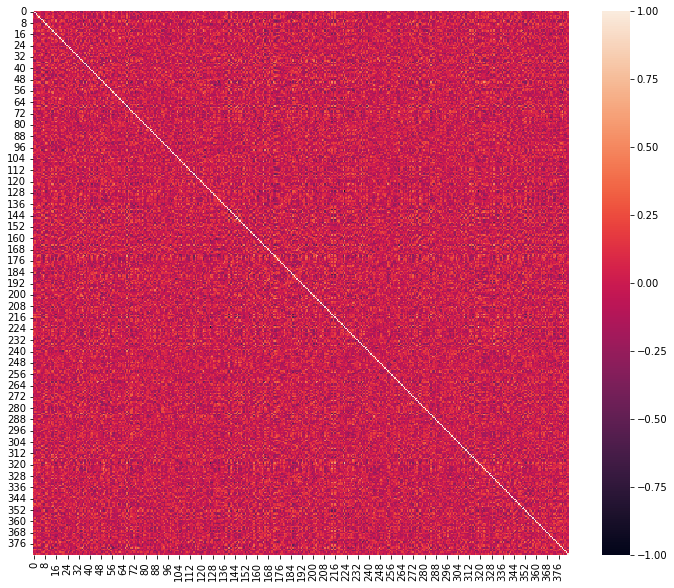

In [659]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(x_transform_test).iloc[:, :].corr(), vmin=-1, vmax=1)

### R2

In [626]:
from sklearn.metrics import r2_score

In [627]:
r2_score(y_true=y_test, y_pred=y_probs_vanilla[:, 1])

0.5372350184877894

In [628]:
r2_score(y_true=y_test, y_pred=y_probs_confound[:, 1])

0.5395650432020981

In [631]:
def r2AndAdjusted(y_true, y_pred, np):
    n = len(y_true)
    
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    r2_adjusted = 1-(1-r2)*(n-1)/(n-np-1)
    
    return r2, r2_adjusted
    

In [632]:
r2AndAdjusted(y_true=y_test, y_pred=y_probs_vanilla[:, 1], np=384)

(0.5372350184877894, -1.0079976154312442)

In [516]:
# auprc_logistic_confounder

# auprc_logistic_vanilla

In [517]:
x_transform_train.shape

(2000, 384)

### Deviance Residuals

In [637]:
def deviance(X, y, model):
    return 2*metrics.log_loss(y, model.predict_proba(X), normalize=False)

In [638]:
deviance(X=x_transform_test, y=y_test, model=clf_vanilla)

313.1833037806102

### Calibration

In [553]:
from sklearn.calibration import calibration_curve
prob_true_vanilla, prob_pred_vanilla = calibration_curve(y_true=y_test, y_prob=y_probs_vanilla[:,1], n_bins=10)
prob_true_confound, prob_pred_confound = calibration_curve(y_true=y_test, y_prob=y_probs_confound[:,1], n_bins=10)


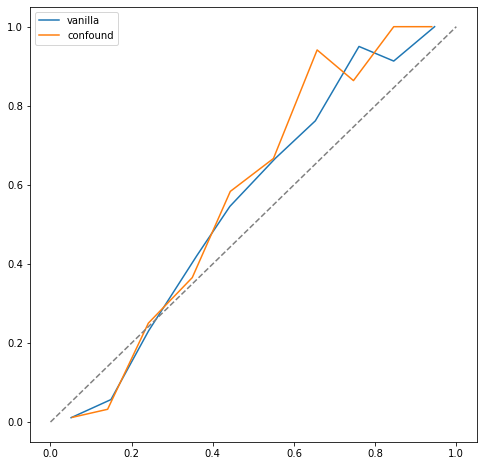

In [568]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(prob_pred_vanilla, prob_true_vanilla, label='vanilla')
ax.plot(prob_pred_confound, prob_true_confound, label='confound')

ax.plot([0,1],[0,1], "--", color='gray')
ax.legend()
